<a href="https://colab.research.google.com/github/cyberholics/Image-classification-with-Pytorch/blob/main/cnn_on_realworld_sample_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from PIL import Image
import cv2, glob,pandas as pd
from glob import glob


In [ ]:
from google.colab import files
files.upload()


In [13]:
import os
# Create the directory for the Kaggle API credentials
os.makedirs('/root/.kaggle', exist_ok=True)
# Move the uploaded kaggle.json to the right place
!mv kaggle.json /root/.kaggle/
# Change file permissions
!chmod 600 /root/.kaggle/kaggle.json


In [14]:
!kaggle datasets download -d sujaykapadnis/smoking


Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/smoking
License(s): Attribution 4.0 International (CC BY 4.0)


In [15]:
!unzip smoking.zip


Archive:  smoking.zip
  inflating: Testing/Testing/notsmoking_0004.jpg  
  inflating: Testing/Testing/notsmoking_0014.jpg  
  inflating: Testing/Testing/notsmoking_0018.jpg  
  inflating: Testing/Testing/notsmoking_0026.jpg  
  inflating: Testing/Testing/notsmoking_0032.jpg  
  inflating: Testing/Testing/notsmoking_0036.jpg  
  inflating: Testing/Testing/notsmoking_0041.jpg  
  inflating: Testing/Testing/notsmoking_0049.jpg  
  inflating: Testing/Testing/notsmoking_0053.jpg  
  inflating: Testing/Testing/notsmoking_0058.jpg  
  inflating: Testing/Testing/notsmoking_0062.jpg  
  inflating: Testing/Testing/notsmoking_0069.jpg  
  inflating: Testing/Testing/notsmoking_0075.jpg  
  inflating: Testing/Testing/notsmoking_0081.jpg  
  inflating: Testing/Testing/notsmoking_0085.jpg  
  inflating: Testing/Testing/notsmoking_0091.jpg  
  inflating: Testing/Testing/notsmoking_0095.jpg  
  inflating: Testing/Testing/notsmoking_0104.jpg  
  inflating: Testing/Testing/notsmoking_0107.jpg  
  inflati

In [42]:
train_data_directory = '/content/Training/Training'
test_data_directory = '/content/Testing/Testing'

In [47]:
# Class to fetch data from dir
from torch.utils.data import Dataset, DataLoader

class smoking_non_smoking(Dataset):
  def __init__(self, directory):
    smoking_images = glob(os.path.join(directory + '/smoking_*.jpg'))
    notsmoking_images = glob(os.path.join(directory + '/notsmoking_*.jpg'))
    self.fpaths = smoking_images + notsmoking_images
    from random import shuffle, seed
    seed(10)
    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('smoking') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

tensor([1.])


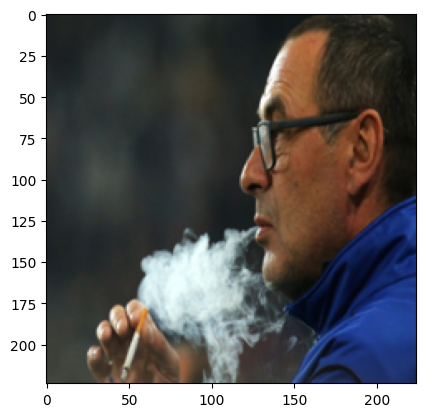

In [50]:
#view sample data
data = smoking_non_smoking(train_data_directory)
im, label = data[500]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [60]:
# define a convolution layer function
def convolution_layer(number_of_input_channel,number_of_output_channel,kernel_size,stride=1):
    return nn.Sequential(
      nn.Conv2d(number_of_input_channel,number_of_output_channel,kernel_size=kernel_size,stride=stride),
      nn.ReLU(),
      nn.BatchNorm2d(number_of_output_channel),
      nn.MaxPool2d(2)
    )


In [61]:
def get_model():
  model = nn.Sequential(
  convolution_layer(3, 64, 3),
  convolution_layer(64, 512, 3),
  convolution_layer(512, 512, 3),
  convolution_layer(512, 512, 3),
  convolution_layer(512, 512, 3),
  convolution_layer(512, 512, 3),
  nn.Flatten(),
  nn.Linear(512, 1),
  nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer=torch.optim.Adam(model.parameters(), lr= 1e-3)
  return model, loss_fn, optimizer

In [63]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [64]:
#function to get data in batches
def get_data():
  train = smoking_non_smoking(train_data_directory)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
  val = smoking_non_smoking(test_data_directory)
  val_dl = DataLoader(val,batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [65]:
#function to train in batches
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [66]:
#function to calculate accuracy
@torch.no_grad()
def accuracy(x, y, model):
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [68]:
#validation loss function
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [69]:
## Training the model (For 5 epochs)
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [73]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, device = device):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_epoch_losses, train_epoch_accuracies = [], []

        # Training Loop
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # Move data to device

            # Forward pass
            outputs = model(x)
            batch_loss = loss_fn(outputs, y)

            # Backward pass
            optimizer.zero_grad()  # Clear gradients from previous step
            batch_loss.backward()
            optimizer.step()  # Update weights

            train_epoch_losses.append(batch_loss.item())

            # Calculate accuracy
            is_correct = accuracy(outputs, y)
            train_epoch_accuracies.extend(is_correct)

        # Calculate mean loss and accuracy for training
        train_epoch_loss = np.mean(train_epoch_losses)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        # Validation Loop
        model.eval()  # Set model to evaluation mode
        val_epoch_accuracies = []
        with torch.no_grad():  # No gradients needed during validation
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                is_correct = accuracy(outputs, y)
                val_epoch_accuracies.extend(is_correct)

        # Calculate mean accuracy for validation
        val_epoch_accuracy = np.mean(val_epoch_accuracies)

        # Save the results for this epoch
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

        # Print results for this epoch
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_epoch_loss:.4f}, "
              f"Train Accuracy: {train_epoch_accuracy:.4f}, "
              f"Validation Accuracy: {val_epoch_accuracy:.4f}")

    return model, train_losses, train_accuracies, val_accuracies

def accuracy(outputs, labels):
    # Assuming binary classification with a sigmoid output
    preds = (outputs > 0.5).float()  # Convert logits to 0 or 1
    return (preds == labels).float()

In [ ]:
model, train_losses, train_accuracies, val_accuracies = train_model(
    model, trn_dl, val_dl , optimizer, loss_fn, epochs=5, device=device
)

Epoch 1/5 - Train Loss: 1.0347, Train Accuracy: 0.6548, Validation Accuracy: 0.5625
Epoch 2/5 - Train Loss: 0.5395, Train Accuracy: 0.7358, Validation Accuracy: 0.7054


In [ ]:
epochs = np.arange(1, 6)
train_losses = train_losses  # Losses for training
train_accuracies = train_accuracies  # Accuracies for training
val_accuracies = val_accuracies  # Accuracies for validation
# Plotting training and validation accuracies and losses
plt.plot(epochs, train_accuracies, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')

# Set major ticks for x-axis and y-axis
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

# title and labels
plt.title('Training and Validation Accuracy / Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')

# y-axis labels as percentage for accuracy and normal for loss
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) if x <= 1 else '{:.2f}'.format(x) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()


In [ ]:
image_path = '/content/Validation/Validation/notsmoking_0006.jpg'

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)[:,:,::-1]
    image = cv2.resize(image, (224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = transform(image).unsqueeze(0)
    return image

# Function to make a prediction
def predict(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.round(output).item()
    return predicted_class

image = preprocess_image(image_path)
image = image.to(device)
predicted_class = predict(model, image)

if predicted_class == 0:
    print(f"Prediction: Not Smoking")
else:
    print(f"Prediction: Smoking")

plt.imshow(image.permute(1, 2, 0).cpu())
plt.title(f"Prediction: {'Smoking' if predicted_class == 1 else 'Not Smoking'}")
plt.show()
